In [ ]:
#hide
#all_slow

# Report

We'll give a brief explanation of LSH (locality sensing hashing) attention. For a step-by-step walk through of LSH-attention we refer to our project documentation: https://arampacha.github.io/reformer_fastai/exploration.LSH.html

In normal attention we perform a matrix multiply of all keys and queries. This is the same as taking the dot product of every  query with every key, and is the source of the quadratic cost of attention. Dot products will be large when vectors are aligned. We then pass the dot products through a softmax (query dim?) that makes relatively large input yet larger. It makes sense that keys and queries that are close together in our high dimensional space will end up with a high score after the softmax. If we could figure out upfront which vectors were close, we might disregard the ones that were far away, since their softmax product most likely would be small. It turns out that the LSH (Adoni et.al) is a suitable algorithm to cluster high dimensional vectors.

## LSH clustering

We could do perfect clustering by comparing each key and query. But that would still leave us with the quadratic cost. LSH instead approximates clustering probabilistically. This means that the cost of it is reduced, but that it can't guarantee perfect accuracy. The intuition behind LSH is described in the blog: https://www.pragmatic.ml/reformer-deep-dive/
1. If we draw a random vector `u` and take the dotproduct with other vectors, we will get positive and negative scores depending if vectors are aligned with `u` or not.
2. If we take the sign of this dot product, we have effectively created two "buckets" for our vectors: '+' and '-'
3. If we draw more lines ("hash rounds"), we create additional buckets in the same way. E.g. 3 lines would give us 2^3=8 buckets.
4. Vectors that end up in the same bucket will have a high probability to be close together, and this probability will go up has the number of hash rounds increases.

![Random_projections.png](images/Random_projections.png)

Note that the reformer paper does LSH via random projections as described in (Andoni et al.,2015).

## LSH-attention

The next step is to add LSH clustering to our new attention meachanism. We refer to figure 2 of the reformer paper that gives a clear overview of the main steps:

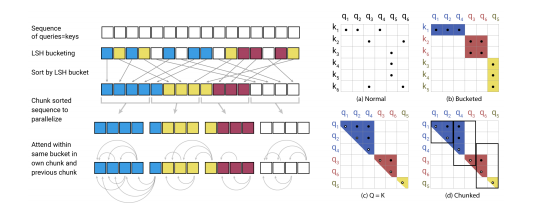

1. First we recieve an input sequence of tokens in original order. In normal attention our tokens are projected in to keys and queries, but we'll set keys and queries to be identical. (see chapter nn)
1. We then use LSH clustering to produce a bucket ID for each item (i.e. key/query). We sort our items first for bucket id and next for position in the original sequence.
1. Group items to equal size chuncks, since number of items in each bucket may vary.
1. Concatenate chunks with their previous chunk to allow for limited inbetween attention. In the diagram we also mask items from other buckets, so that only in-bucket attention is allowed.
1. Calculate a normal dot product attention **within** each concatenated chunk.
1. Unchunk and unsort all items.

![LSH_main-steps.png](images/LSH_main-steps.png)

## LSH attention complexity

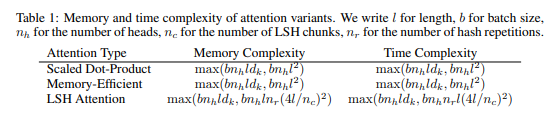

According to the reformer paper the time and memory complexities of scaled dot produc and LSH attention are:

Attention Type|Memory Complexity|Time Complexity
--|--|--
Scaled Dot-Product | $max(bn_hld_k, bn_hl^2)$ | $max(bn_hld_k, bn_hl^2)$
LSH Attention | $max(bn_hld_k, bn_hln_r(4l/n_c)^2)$ | $max(bn_hld_k, bn_hn_rl(4l/n_c)^2)$

Where: 
* $l$ is the length of the input sequence
* $b$ is the batch size
* $n_h$ is the number of heads in multihead attention.
* $n_c$ is the number of LSH chunks.
* $n_r$ is the number of hash rounds
* $d_k$ is the model dimension

Language models typically benefit from long input sequeneces ($l$) to give the model a longer context(ref), so we often want to make $l$ large. This means that the cost is usually dominated by the latter part of the max in the table above, i.e. $l$ is usually larger than $d_k$. 

In this case dot product attention has a quadratic cost in both time and memory that depends on $l^2$. If we want to compare LSH-attention to dot product attention, we can compare $ln_r(4l/n_c)^2$ to $l^2$, since $b$ and $n_h$ are common terms. This means that the cost of LSH relative to normal attention is linear w.r.t. $n_r$, but decreases quadratically with $n_c$. In our implementation we did not set $n_c$ directly, but rater define a bucket size, $b_s$ where $n_c$ = $l/b_s$. 

We can therefor rewrite the lsh complexity as $n_r(4b_s)^2l$, which is linearly dependent on $l$. It also makes intuitive sense that the complexity of LSH-attention grows quadratically with $b_s$, since we do normal dot product attention within each chunk.